In [1]:
import copy
import os.path
import pandas as pd
import numpy as np
from scipy import stats
#Importing libraries needed
# for .ipynb_checkpoints/ tab

import matplotlib.pyplot as plt
import seaborn as sns
#pip install statannot
#from statannot import add_stat_annotation

In [2]:
pwd

'path/to/fmt1'

In [3]:
df = pd.read_excel(os.path.join(os.path.expanduser('~'), 'path/to/fmt1/KNedit_v02.xlsx'),
                   index_col=0, header=[0, 1])
#loads Kraken file formatted for processing

In [4]:
df.columns = df.columns.rename("Group", level=1)
df.columns = df.columns.rename("ID", level=0)
#Sets up formating

In [5]:
dfA=df.T
dfAd = dfA.reset_index()
#Reformat data by taking the transpose
dfAd.loc[59:79,'Group']='TD'
#***Specific to the study specific Kraken file utilized for the purposes of designating the TD group***

In [6]:
log10_df= np.log10(df)

log10_dfT = log10_df.T
log10_dfT2 = log10_dfT.reset_index()
log10_dfT2.loc[59:79,'Group']='TD'

<ipython-input-6-feeb40dcd265>:1: RuntimeWarning: divide by zero encountered in log10
  log10_df= np.log10(df)


In [9]:
def uniTest(ASD_full,NEU_full):
    #The purpose of this function is to perform a univariate statistical test 
    
    zero_ASD=(np.count_nonzero(ASD_full))-len(ASD_full)+3
    zer0_TD=np.count_nonzero(NEU_full)-len(NEU_full)+3
    if zero_ASD>0 and zer0_TD> 0:
        p_ASD = stats.normaltest(ASD_full)
        p_TD = stats.normaltest(NEU_full)
        #Check performed to determine if there are high rates of missing data
        #Cases in which there are fewer than 4 samples are not analyzedt
        #Normality is determined to evaluate choice needed for test selection 
        if p_ASD[1]<.05 or p_TD[1]<.05:
            #When the normality assumption fails in either datasets case, a non-parametric test is considered
            statistic,p_value=stats.ks_2samp(ASD_full, NEU_full)
            #Samples are evaluated for whether they likely come from the same or different distributions 
            if p_value>.05:
                #If samples are likley drawn from the same type of distribution a Mann-Whitney U-test is performed
                statistic,p_value_mann=stats.mannwhitneyu(ASD_full,NEU_full)
                return p_value_mann*2,"Mann-Whitney U-Test"
            else:
                Adj_mean=((np.mean(ASD_full)*len(ASD_full))+(np.mean(NEU_full)*len(NEU_full)))/(len(ASD_full)+len(NEU_full))
                new_ASD=ASD_full-Adj_mean
                new_TD=NEU_full-Adj_mean
                statistic,p_value=stats.ks_2samp(new_ASD, new_TD)
                if p_value>.05:
                    statistic,tru_p_value_mann=stats.mannwhitneyu(new_ASD,new_TD)
                    return tru_p_value_mann*2,"Mann-Whitney U-Test"
                else:
                    var_t,var_p=stats.ttest_ind(new_ASD,new_TD,  equal_var=False)
                    
                    return var_p, "Welch's Test"
        else:
            statistic_v,var_pvalue=stats.levene(ASD_full, NEU_full)
            if var_pvalue>.05:
                var_t,var_p=stats.ttest_ind(ASD_full, NEU_full,  equal_var=True)
                return var_p, " Equal Variance t-Test"
            else:
                var_t,var_p=stats.ttest_ind(ASD_full, NEU_full,  equal_var=False)
                return var_p, "Welch's Test"
    else:
        return 1, "None-Missing Values"

In [10]:
def boxPlotMakerFull_paired_plus(df2,taxa_target):
    #This function will output a boxplot for a specific taxa input as a string
    #Example using general data
    #boxPlotMakerFull(df2,"d__Bacteria|g__Thermobaculum|s__Thermobaculum_terrenum")
    
    Major_Donor_Values=df2[df2["Group"]=='MajorDonor']
    Minor_Donor_Values=df2[df2["Group"]=='MaintenanceDonor']
    Baseline_values=df2[df2["Group"]=='Baseline']
    Neurotypical_values=df2[df2["Group"]=='TD']  ### old one was Neurotypical
    MTT_10=df2[df2["Group"]=='MTT_10wk']
    MTT_2yr=df2[df2["Group"]=='MTT_2yr']
    
    sam_1=Neurotypical_values[taxa_target]
    sam_2=Baseline_values[taxa_target]
    sam_3=MTT_10[taxa_target]
    sam_4=MTT_2yr[taxa_target]
    sam_5=sam_2.drop(sam_2.index[[16,17]])
    #Remove two samples from 2yr to compare with baseline levels
    
    p_value,test_type=uniTest(sam_1,sam_2)
    p_value_paired,test_paired=uniTest_paired(sam_2,sam_3)
    p_value_paired_2,test_paired_2=uniTest_paired(sam_5,sam_4) 
    
    all_p_full=[' ', pConvert(p_value_paired),pConvert(p_value_paired_2),pConvert(p_value)]
    #above line Determine all p-values to display, in the order of box plot, baseline empty, other will show the stars
    
    if p_value<.05:
        fdr_true=FDRfull(sam_1,sam_2)
        if fdr_true>.05:
            #all_p_full[3]=all_p_full[3]+'!'
            all_p_full[3]='ns'
    else:
            fdr_true=1;
            all_p_full[3]='ns'
    
    if p_value_paired<.05:
        fdr_true_10wk=FDRfullPaired(sam_2,sam_3)
        if fdr_true_10wk>.05:
            #all_p_full[3]=all_p_full[3]+'!'
            all_p_full[1]='ns'
    else:
            fdr_true_10wk=1;
            all_p_full[1]='ns'
    if p_value_paired_2<.05:
        fdr_true_2yr=FDRfullPaired(sam_4,sam_5)
        if fdr_true_2yr>.05:
            #all_p_full[3]=all_p_full[3]+'!'
            all_p_full[2]='ns';
    else:
            fdr_true_2yr=1;
            all_p_full[2]='ns'
            
            
            
            
    out_mess="p-value= "+str(round(p_value, 2))+str(test_type)+" FDR= "+str(round(fdr_true, 2))+' Paired p-value '+str(round(p_value_paired, 2))
    #Major_mean=np.mean(Major_Donor_Values[taxa_target])
    #Minor_mean=np.mean(Minor_Donor_Values[taxa_target])
    Major_median=np.median(Major_Donor_Values[taxa_target])
    Minor_median=np.median(Minor_Donor_Values[taxa_target])
    df3=df2.drop([0, 1, 2, 3, 4, 5, 6])
    colors = ['#78C850', '#F08030', '#6890F0','#A040A0','#F8D030', '#E0C068', '#EE99AC', '#C03028', '#F85888', '#B8A038', '#705898', '#F4A460', '#FF00FF', '#0000FF', '#00FFFF', '#ADFF2F', '#20B2AA', '#FF0000', '#C0C0C0']
    #determine the size of the figure/plot, facecolor for the figure background
    fig = plt.figure(figsize=(7, 6), facecolor='white') ##edgecolor='red'
    ax = sns.swarmplot(data=df3, x='Group', y=taxa_target, hue='ID',
                   size=12, palette=colors, facecolor='none')
    ax.axhline(xmin=-1, xmax=1, y=Minor_median, color='r', 
           linestyle='--', lw=2, label ="Maint_Donor(median)")
    
    #ax.text( 0,Minor_mean*5,out_mess, style='italic', fontsize=12, 
    #    bbox={'facecolor': 'grey', 'alpha': 0.5,  })
    ax.axhline(xmin=-1, xmax=1, y=Major_median, color='b', 
           linestyle='--', lw=2, label ="Major_Donor(median)")
    ##change the font size of x (abundance) n y (group name) axis ticks
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13) #fontweight='semibold'
    
    # to remove the border/frame of figure
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    b=sns.boxplot(data=df3, x="Group", y=taxa_target,
                 showcaps=True,boxprops={'facecolor':'none'},
                 ax=ax)
   
    b.set_xlabel("",fontsize=15) #fontweight='bold')
    b.set_ylabel("log10 RA of "+taxa_target, fontsize=14, style='italic') #fontweight='semibold',
    
    #to put the title in the center
    #plt.title(taxa_target, fontsize=14)
    y_max_v=b.get_yticks()
    #Dermine where to place output on test significance 
    
    for xtick in b.get_xticks():
        
        #b.text(xtick, align=outside, all_p_full[xtick], 
        #b.text(xtick, (y_max_v[6]+y_max_v[7])/2, all_p_full[xtick],
        #b.text(xtick,(y_max_v[-1]+y_max_v[-2])/2, all_p_full[xtick], ##good one
        #b.text(xtick,(y_max_v[6]+y_max_v[-1])/2, all_p_full[xtick],  ##2nd good one
        b.text(xtick,(y_max_v[6]+y_max_v[-1])/2, all_p_full[xtick],
      #horizontalalignment='center',fontsize=20,color='b',weight='semibold')   
       horizontalalignment='center',fontsize=14,color='k', weight='semibold') #va='bottom'
    
    plt.legend(bbox_to_anchor=(1, 1), loc=2, facecolor='white');
    fig1 = plt.gcf()
    
    #line_sub = taxa_target.replace('|', '____')
    #fig1.savefig(line_sub+'.png', bbox_inches='tight')
        
    #if fdr_true<.05 and p_value<.05:
        #print(p_value) ### for between ASD vs TD to print
        
    if fdr_true_10wk<.05 and p_value_paired<.05:    #ASD vs MTT_10wk to print
        print(p_value_paired)
    
    ###BE CAREFUL    
    #if fdr_true_10wk>.05 and p_value_paired>.05:    #ASD vs MTT_10wk "non-significant to print (e.g. Bifi species)
        #print(p_value_paired)
    #if fdr_true_2yr<.05 and p_value_paired_2<.05:
        #print(p_value_paired_2) ### for between ASD vs MTT2yr to print
                
        #line_sub = taxa_target.replace('|', '____')
        #fig1.savefig(line_sub+'.png', bbox_inches='tight')
        #fig1.savefig(line_sub+'.svg', bbox_inches='tight')
        plt.show()
        #for KO with long name
        first_part_name = taxa_target.split(":")
        fig1.savefig(first_part_name[0]+'.svg', bbox_inches='tight')
        fig1.savefig(first_part_name[0]+'.png', bbox_inches='tight', dpi=500)
        
        #for taxa
        fig1.savefig(taxa_target+'.svg', bbox_inches='tight')
        fig1.savefig(taxa_target+'.png', bbox_inches='tight', dpi=500)
        
        
        
        #plt.imshow(fig1)
        #plt.axis("off")
        #plt.show()
        #fig1.clf()
        
    #fig1.clf()       ### both clf lines will clear each figure after each iteration for figure, helps to save the figure in local directory
    #plt.clf()        ### if both lines are off (#) means just to see the figure
    # ax[1, 1].set_title("Exponential function") ### to set the taxa name as title
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)

In [11]:
def boxPlotMakerFull_paired_combine(df2,dfA,taxa_target):
    #This function will output a boxplot for a specific taxa input as a string
    #Example using general data
    #boxPlotMakerFull(df2,"d__Bacteria|g__Thermobaculum|s__Thermobaculum_terrenum")
    textstr = 'fill_test'
    Major_Donor_Values=df2[df2["Group"]=='MajorDonor']
    Minor_Donor_Values=df2[df2["Group"]=='MaintenanceDonor']
    Baseline_values=dfA[dfA["Group"]=='Baseline']
    Neurotypical_values=dfA[dfA["Group"]=='TD']  ### old one was Neurotypical
    MTT_10=dfA[dfA["Group"]=='MTT_10wk']
    MTT_2yr=dfA[dfA["Group"]=='MTT_2yr']
    
    sam_1=Neurotypical_values[taxa_target]
    sam_2=Baseline_values[taxa_target]
    sam_3=MTT_10[taxa_target]
    sam_4=MTT_2yr[taxa_target]
    sam_5=sam_2.drop(sam_2.index[[16,17]])
    #Remove two samples from 2yr to compare with baseline levels
    
    p_value,test_type=uniTest(sam_1,sam_2)
    p_value_paired,test_paired=uniTest_paired(sam_2,sam_3)
    p_value_paired_2,test_paired_2=uniTest_paired(sam_5,sam_4) 
    
    all_p_full=[' ', pConvert(p_value_paired),pConvert(p_value_paired_2),pConvert(p_value)]
    #above line Determine all p-values to display, in the order of box plot, baseline empty, other will show the stars
    [taxa_target_log,p_value_log,test_type_log,fdr_true_log, p_value_paired_log,test_paired_log, fdr_pair_one_log, p_value_paired_2_log,test_paired_2_log, fdr_pair_two_log]=FullDataUniTest(df2,taxa_target)
    if p_value<.05:
        fdr_true=FDRfull(sam_1,sam_2)
        if fdr_true>.05:
            log_form_p=pConvert(p_value_paired_log)
            #all_p_full[3]=all_p_full[3]+'!'
            if p_value_log<.05 and fdr_true_log<.1:
                all_p_full[3]='#'
            else:
                fdr_true=1;
                all_p_full[3]='ns'
    else:
            
            if p_value_log<.05 and fdr_true_log<.1:
                all_p_full[3]='#'
            else:
                fdr_true=1;
                all_p_full[3]='ns'
    
    if p_value_paired<.05:
        fdr_true_10wk=FDRfullPaired(sam_2,sam_3)
        if fdr_true_10wk>.05:
            #all_p_full[3]=all_p_full[3]+'!'
            if p_value_paired_log<.05 and fdr_pair_one_log<.1:
                all_p_full[1]='#'
            else:
                fdr_true=1;
                all_p_full[1]='ns'
    else:
            fdr_true_10wk=1;
            if p_value_paired_log<.05 and fdr_pair_one_log<.1:
                all_p_full[1]='#'
            else:
                fdr_true=1;
                all_p_full[1]='ns'
    if p_value_paired_2<.05:
        fdr_true_2yr=FDRfullPaired(sam_4,sam_5)
        if fdr_true_2yr>.05:
            #all_p_full[3]=all_p_full[3]+'!'
            if fdr_pair_two_log<.05 and fdr_pair_two_log<.1:
                all_p_full[2]='#'
            else:
                
                fdr_true_2yr=1;
                all_p_full[2]='ns'
    else:
        if fdr_pair_two_log<.05 and fdr_pair_two_log<.1:
            all_p_full[2]='#'
        else:
                
            fdr_true_2yr=1;
            all_p_full[2]='ns'
            
            
            
            
    out_mess="p-value= "+str(round(p_value, 2))+str(test_type)+" FDR= "+str(round(fdr_true, 2))+' Paired p-value '+str(round(p_value_paired, 2))
    #Major_mean=np.mean(Major_Donor_Values[taxa_target])
    #Minor_mean=np.mean(Minor_Donor_Values[taxa_target])
    Major_median=np.median(Major_Donor_Values[taxa_target])
    Minor_median=np.median(Minor_Donor_Values[taxa_target])
    df3=df2.drop([0, 1, 2, 3, 4, 5, 6])
    colors = ['#78C850', '#F08030', '#6890F0','#A040A0','#F8D030', '#E0C068', '#EE99AC', '#C03028', '#F85888', '#B8A038', '#705898', '#F4A460', '#FF00FF', '#0000FF', '#00FFFF', '#ADFF2F', '#20B2AA', '#FF0000', '#C0C0C0']
    #determine the size of the figure/plot, facecolor for the figure background
    fig = plt.figure(figsize=(7, 6), facecolor='white') ##edgecolor='red'
    ax = sns.swarmplot(data=df3, x='Group', y=taxa_target, hue='ID',
                   size=12, palette=colors, facecolor='none')
    ax.axhline(xmin=-1, xmax=1, y=Minor_median, color='r', 
           linestyle='--', lw=2, label ="Maint_Donor(median)")
    
    #ax.text( 0,Minor_mean*5,out_mess, style='italic', fontsize=12, 
    #    bbox={'facecolor': 'grey', 'alpha': 0.5,  })
    ax.axhline(xmin=-1, xmax=1, y=Major_median, color='b', 
           linestyle='--', lw=2, label ="Major_Donor(median)")
    ##change the font size of x (abundance) n y (group name) axis ticks
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13) #fontweight='semibold'
    
    # to remove the border/frame of figure
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    b=sns.boxplot(data=df3, x="Group", y=taxa_target,
                 showcaps=True,boxprops={'facecolor':'none'},
                 ax=ax)
   
    b.set_xlabel("",fontsize=15) #fontweight='bold')
    b.set_ylabel("log10 RA of "+taxa_target, fontsize=14, style='italic') #fontweight='semibold',
    
    #to put the title in the center
    #plt.title(taxa_target, fontsize=14)
    y_max_v=b.get_yticks()
    #Dermine where to place output on test significance 
    
   # for xtick in b.get_xticks():
        
        #b.text(xtick, align=outside, all_p_full[xtick], 
        #b.text(xtick, (y_max_v[6]+y_max_v[7])/2, all_p_full[xtick],
        #b.text(xtick,(y_max_v[-1]+y_max_v[-2])/2, all_p_full[xtick], ##good one
        #b.text(xtick,(y_max_v[6]+y_max_v[-1])/2, all_p_full[xtick],  ##2nd good one
       # b.text(xtick,(y_max_v[6]+y_max_v[-1])/2, all_p_full[xtick],
      #horizontalalignment='center',fontsize=20,color='b',weight='semibold')   
    #    horizontalalignment='center',fontsize=14,color='k', weight='semibold') #va='bottom'
    
    plt.legend(bbox_to_anchor=(1, 1), loc=2, facecolor='white');
    plt.figtext(.4, .9, all_p_full[1], fontsize=14)
    plt.figtext(.6, .9, all_p_full[2], fontsize=14)
    plt.figtext(.79, .9, all_p_full[3], fontsize=14)
   # plt.subplots_adjust(top=0.9)
    
    fig1 = plt.gcf()
    
    #line_sub = taxa_target.replace('|', '____')
    #fig1.savefig(line_sub+'.png', bbox_inches='tight')
        
    #if fdr_true<.05 and p_value<.05:
        #print(p_value) ### for between ASD vs TD to print
        
    if fdr_true_10wk<.05 and p_value_paired<.05:    #ASD vs MTT_10wk to print
        print(p_value_paired)
    
    ###BE CAREFUL    
    #if fdr_true_10wk>.05 and p_value_paired>.05:    #ASD vs MTT_10wk "non-significant to print (e.g. Bifi species)
        #print(p_value_paired)
    #if fdr_true_2yr<.05 and p_value_paired_2<.05:
        #print(p_value_paired_2) ### for between ASD vs MTT2yr to print
                
        #line_sub = taxa_target.replace('|', '____')
        #fig1.savefig(line_sub+'.png', bbox_inches='tight')
        #fig1.savefig(line_sub+'.svg', bbox_inches='tight')
        plt.show()
        fig1.savefig(taxa_target+'.svg', bbox_inches='tight')
        fig1.savefig(taxa_target+'.png', bbox_inches='tight', dpi=500)
        #plt.imshow(fig1)
        #plt.axis("off")
        #plt.show()
        #fig1.clf()
        
    #fig1.clf()       ### both clf lines will clear each figure after each iteration for figure, helps to save the figure in local directory
    #plt.clf()        ### if both lines are off (#) means just to see the figure
    # ax[1, 1].set_title("Exponential function") ### to set the taxa name as title
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)

In [12]:
def pConvert(p_value):
    #Determine the significane of the p-value for display purposes
    if p_value<.001:
        return '***'
    elif p_value<.01:
        return '**'
    elif p_value<.05:
        return '*'
    else:
        return ' '

In [13]:
def FDRhalf(ASD_full,NEU_full):
    #This function will conduct half og the FDR analysis
    out_count=0;
    for i in range(len(ASD_full)-1):
        ASD_sub=copy.deepcopy(list(ASD_full))
        temp_hold=ASD_sub.pop(i)
        p_value,test_type=uniTest(ASD_sub,NEU_full)
        if p_value>.05:
            out_count=out_count+1
    return out_count

In [14]:
def FDRfull(ASD_full,NEU_full):
    #Combines FDR for both groups 
    return (FDRhalf(ASD_full,NEU_full)+FDRhalf(NEU_full,ASD_full))/(len(ASD_full)+len(NEU_full))

In [15]:
def uniTest_paired(ASD_full,NEU_full):
    #The purpose of this function is to perform a univariate statistical test 
    
    zero_ASD=(np.count_nonzero(ASD_full))-len(ASD_full)+3
    zer0_TD=np.count_nonzero(NEU_full)-len(NEU_full)+3
    if zero_ASD>0 and zer0_TD> 0:
        p_ASD = stats.normaltest(ASD_full)
        p_TD = stats.normaltest(NEU_full)
        if p_ASD[1]<.05 or p_TD[1]<.05:
            statistic,p_value=stats.ks_2samp(ASD_full, NEU_full)
            if p_value>.05:
                statistic,p_value_mann=stats.wilcoxon(ASD_full,NEU_full)
                return p_value_mann,"Wilcoxon Test"
            else:
                Adj_mean=((np.mean(ASD_full)*len(ASD_full))+(np.mean(NEU_full)*len(NEU_full)))/(len(ASD_full)+len(NEU_full))
                new_ASD=ASD_full-Adj_mean
                new_TD=NEU_full-Adj_mean
                statistic,p_value=stats.ks_2samp(new_ASD, new_TD)
                if p_value>.05:
                    statistic,p_value_mann=stats.wilcoxon(ASD_full,NEU_full)
                    return p_value_mann,"Wilcoxon Test"
                else:
                    statistic,p_value_mann=stats.wilcoxon(ASD_full,NEU_full)
                    
                    return p_value_mann,"Wilcoxon Test"
        else:
            statistic_v,var_pvalue=stats.levene(ASD_full, NEU_full)
            if var_pvalue>.05:
                var_t,var_p=stats.ttest_rel(ASD_full, NEU_full)
                return var_p, " Paired t-test"
            else:
                var_t,var_p=stats.ttest_rel(ASD_full, NEU_full)
                return var_p, "Paired t-test"
    else:
        return 1, "None-Missing Values"

In [16]:
def FDRhalfPaired(ASD_full,NEU_full):
    #This function will conduct half og the FDR analysis
    out_count=0;
    for i in range(len(ASD_full)-1):
        ASD_sub=copy.deepcopy(list(ASD_full))
        temp_hold=ASD_sub.pop(i)
        TD_sub=copy.deepcopy(list(NEU_full))
        temp_hold=TD_sub.pop(i)
        p_value,test_type=uniTest_paired(ASD_sub,TD_sub)
        if p_value>.05:
            out_count=out_count+1
    return out_count

In [17]:
def FDRfullPaired(ASD_full,NEU_full):
    #Combines FDR for both groups 
    return (FDRhalfPaired(ASD_full,NEU_full)+FDRhalfPaired(NEU_full,ASD_full))/(len(ASD_full)+len(NEU_full))

In [18]:
taxaNames_Full = list(dfA)
#remove ID and Group
taxaNames_Full.pop(0)
taxaNames_Full.pop(0)

'Bifidobacterium_species'

In [19]:
def FullDataUniTest(df2,taxa_target):
    #This function will output a boxplot for a specific taxa input as a string
    #Example using general data
    #boxPlotMakerFull(df2,"d__Bacteria|g__Thermobaculum|s__Thermobaculum_terrenum")
    
 
    Baseline_values=df2[df2["Group"]=='Baseline']
    Neurotypical_values=df2[df2["Group"]=='TD']
    MTT_10=df2[df2["Group"]=='MTT_10wk']
    MTT_2yr=df2[df2["Group"]=='MTT_2yr']
    
    sam_1=Neurotypical_values[taxa_target]
    sam_2=Baseline_values[taxa_target]
    sam_3=MTT_10[taxa_target]
    sam_4=MTT_2yr[taxa_target]
    sam_5=sam_2.drop(sam_2.index[[16,17]])
    
    #Remove two samples from 2yr to compare with baseline levels
    
    p_value,test_type=uniTest(sam_1,sam_2)
    p_value_paired,test_paired=uniTest_paired(sam_2,sam_3)
    p_value_paired_2,test_paired_2=uniTest_paired(sam_5,sam_4)
    if p_value<.1:
        fdr_true=FDRfull(sam_1,sam_2)
    else:
            fdr_true=1
    if p_value_paired<.1:
        fdr_pair_one=FDRfullPaired(sam_2,sam_3)
    else:
            fdr_pair_one=1
    if p_value_paired_2<.1:
        fdr_pair_two=FDRfullPaired(sam_4,sam_5)
    else:
            fdr_pair_two=1
    return taxa_target,p_value,test_type,fdr_true, p_value_paired,test_paired, fdr_pair_one, p_value_paired_2,test_paired_2, fdr_pair_two

In [ ]:
************************* STARTING of skip zone*******************

In [28]:
#full_results_all=[]
#for column in taxaNames_Full:
    #try:
        #output_cat=FullDataUniTest(dfAd,column)
        #full_results_all.append(output_cat)
   # except:
        #print('error missing values')

In [29]:
#uniOutput = pd.DataFrame(full_results_all)
#uniOutput.to_csv('new_py_results_5192021.csv')

In [30]:
#full_results_all

In [31]:
#Change to whatever list you want
#CurrentList = pd.read_csv(os.path.join(os.path.expanduser('~'), 'D://ResearchBioDesign_ASU//Autism-MetagenomData//Metagenome_2020//kraken2//merge_79_samples//jupyter//donors_allSamples_Feb21/June2021/new_py_results_5192021.csv'),
                   #index_col=0, header=[0])


In [32]:
#Get the names to include
#namesSampleIncluded=list(CurrentList.iloc[:,0])

In [33]:
#subset_results_all=[]
#for column in namesSampleIncluded:
    #try:
        #boxPlotMakerFull_paired_combine(log10_dfT2,dfAd,column)
       
    #except:
        #print('error missing values')

In [34]:
#boxPlotMakerFull_paired_combine(log10_dfT2,dfAd,'Actinomyces_sp._oral_taxon_897')

In [ ]:
************************* END of skip zone*******************

In [ ]:
************ below steps save the image too***************

C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing a

0.022325437492304773


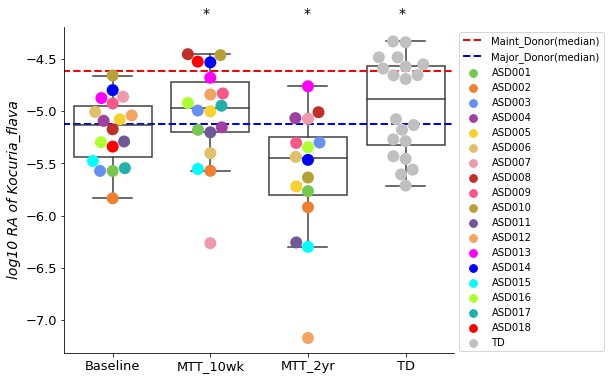

In [21]:
boxPlotMakerFull_paired_combine(log10_dfT2,dfAd,'Kocuria_flava')

C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing a

0.0028332152987737428


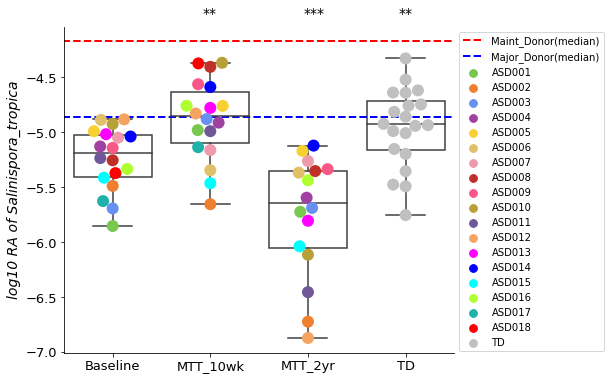

In [22]:
boxPlotMakerFull_paired_combine(log10_dfT2,dfAd,'Salinispora_tropica')

C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing a

0.0138702392578125


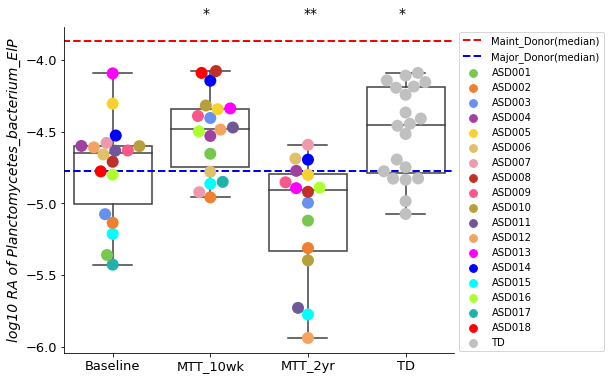

In [23]:
boxPlotMakerFull_paired_combine(log10_dfT2,dfAd,'Planctomycetes_bacterium_ElP')

C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing a

0.011225318174611454


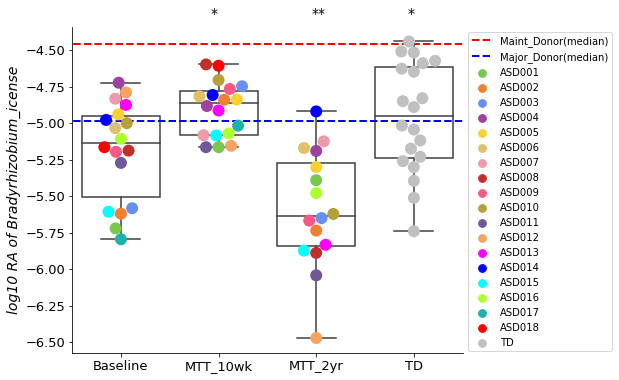

In [24]:
boxPlotMakerFull_paired_combine(log10_dfT2,dfAd,'Bradyrhizobium_icense')

C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing a

0.01656576922619086


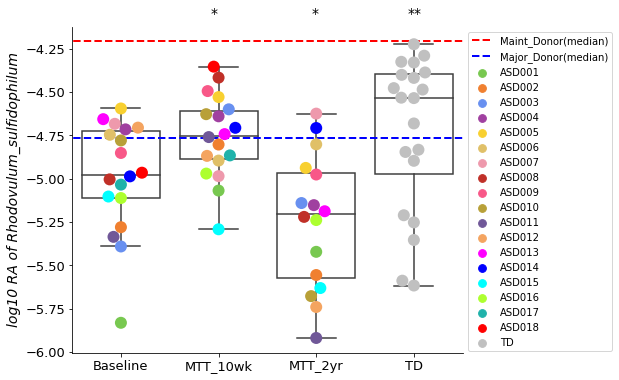

In [25]:
boxPlotMakerFull_paired_combine(log10_dfT2,dfAd,'Rhodovulum_sulfidophilum')

C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing a

0.010406494140625


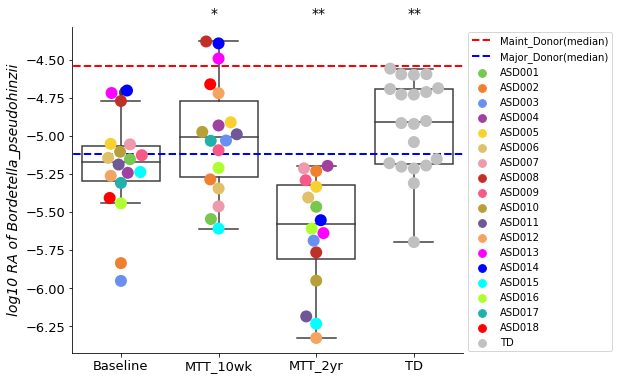

In [26]:
boxPlotMakerFull_paired_combine(log10_dfT2,dfAd,'Bordetella_pseudohinzii')

C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\knirmalk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing a

0.024323315975747075


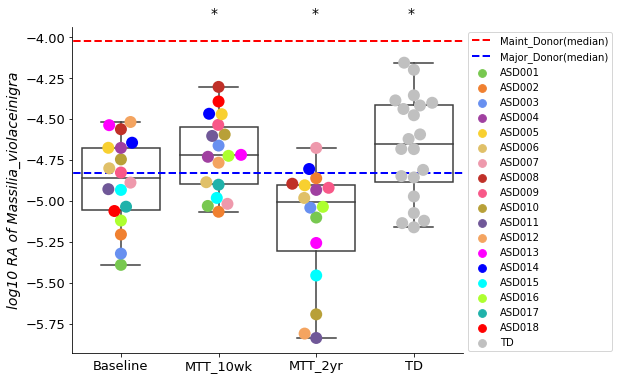

In [27]:
boxPlotMakerFull_paired_combine(log10_dfT2,dfAd,'Massilia_violaceinigra')

In [ ]:
# Rhodococcus_ruber for log significant with # sign